In [1]:
! ls localmz_N* >regional_mz_fft.txt

In [1]:
!cat regional_mz_fft.txt

localmz_N8_J_0.6366197723675814.hdf5
localmz_N10_J_0.6366197723675814.hdf5
localmz_N12_J_0.6366197723675814.hdf5


localmz_N8_J_0.6366197723675814.hdf5 0
localmz_N10_J_0.6366197723675814.hdf5 1
localmz_N12_J_0.6366197723675814.hdf5 2


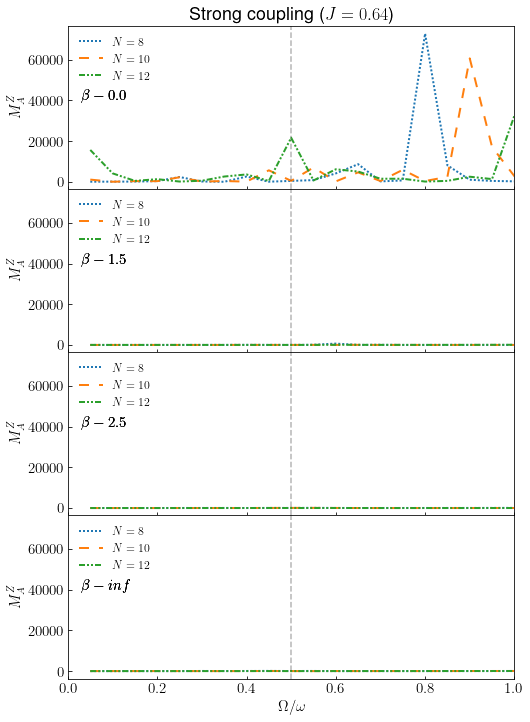

In [67]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel

plt.rcParams.update({"figure.figsize": (8, 12),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 1, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.25, hspace=0.0)

steps = 20001
freq_threshold = 0.1
legendftsize = 12

omega = 20.0
w = omega
T = 2 * np.pi/w


Ns = []


with open("regional_mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    btfr = np.zeros((4,x))
    
    for xx in range(0,x):
        filename = lines[xx][:-1]
        print(filename, xx)
        
        with h5py.File(filename, "r") as f:
            datas = f['mz'][()]
            times = f['times'][()]
            betas = f['betas'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']   
            
        
        
        for b, beta in enumerate(betas):
            
            datap = np.zeros((N, len(times)))
            for i in range(N):
                datap[i] = datas[b][i][0]
                
            mz_dt = [datap[m] for m in range(int(N/2),N)]
            mz_data = np.sum(mz_dt, axis=0) * 2/N
            
            frequencies = np.fft.fftfreq(mz_data.size, d = 1/steps)
            fft_values = np.fft.fft(mz_data - np.average(mz_data))
            
            mask = frequencies > freq_threshold
            y = np.abs(fft_values[mask])**2
            x = frequencies[mask]
            
            line, = axs[b].plot(x/w, y,linewidth=2.0,label = fr'$N={N}$', linestyle = linestyle_tuple[xx][1])
            axs[b].axvline(x=0.5, color = 'black', ls = 'dashed',alpha = 0.1)            
            
            peak_idx, peak_props = find_peaks(y, prominence = 0.5, distance = None)
            peak_pos = x[peak_idx]/w                     
            
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            most_prominent_idx = np.argmax(before_proms)
            prominent_freq_before = peaks_before[most_prominent_idx]

            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            most_prominent_idx = np.argmax(after_proms)
            prominent_freq_after = peaks_after[most_prominent_idx]
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            btfr[b][xx] = beat_freq         
            
            axs[b].tick_params(which='both', axis="x", direction="in")
            axs[b].tick_params(which='both', axis="y", direction="in")
            axs[b].set_xlim(0,1)
            #axs[b].set_ylim(bottom = 0.5)
            #axs[b].set_yscale('log')
            axs[b].legend(fontsize = legendftsize, frameon = False, loc =2)
            axs[b].text(0.03, 40000, fr"$\beta-{beta}$")            
            axs[b].set_ylabel(r"$M^Z_A$")     
        Ns.append(N)        

'''        
for i in range(4):
    beta = betas[i]
    axs[-1].plot(Ns, btfr[i], label = fr"$\beta = {beta}$")
    axs[-1].scatter(Ns, btfr[i])
    
axs[-1].set_xticks([8,10,12])
axs[-1].set_xlabel(r"$N$")    
axs[-1].set_ylabel("Beat freq") 
axs[-1].legend(frameon =False, loc = 6, fontsize = 12) 

'''
axs[0].set_title(fr"Strong coupling ($J={Jvalue:2.2f}$)")
axs[-1].set_xlabel(r"$\Omega/\omega$")


figname = 'regional_mag_FFT_strong.pdf'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)

plt.show()

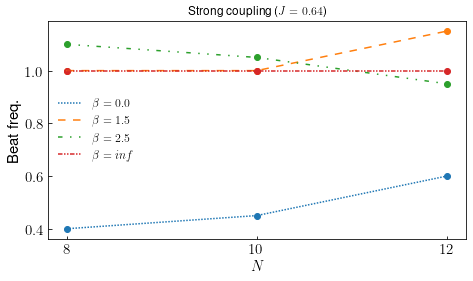

In [68]:
plt.rcParams.update({"figure.figsize": (7.5, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]



for i in range(4):
    beta = betas[i]
    plt.plot(Ns, btfr[i], label = fr"$\beta = {beta}$", ls = linestyle_tuple[i][1])
    plt.scatter(Ns, btfr[i])
    
plt.xticks([8,10,12])

plt.title(fr"Strong coupling ($J={Jvalue:2.2f}$)", fontsize = 12)
plt.xlabel(r"$N$")    
plt.ylabel("Beat freq.") 

plt.tick_params(which='both', axis="x", direction="in")
plt.tick_params(which='both', axis="y", direction="in")
plt.legend(frameon =False, loc = 6, fontsize = 12)    

figname = 'beatFr_regional_mag_FFT_strong.pdf'
plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)

plt.show()